<a href="https://colab.research.google.com/github/yeshavyas27/multimodal_finetune/blob/main/moondream_finetune_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# moondream finetune 🌛
[Demo gradio app ](https://huggingface.co/spaces/yeshavyas27/moondream-finetuned-demo/blob/main/app.py)

*moondream is a computer-vision model that can answer real-world questions about images. It's tiny by today's models, with only 1.6B parameters.*

P.S: I found this really interesting article on multimodal AI - [Vision Language models are blind](https://vlmsareblind.github.io/)

Make the necessary installations


In [ ]:
!pip install requests==2.31.0 pyarrow==14.0.1 torch transformers timm einops datasets bitsandbytes accelerate
!pip install flash-attn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 32.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121

Loading the dataset which will be used to finetune the model
(Due to less computational resources I only used 30 examples for finetuning). Note that I will be finetuning on a VQA (Visual Question Answering) dataset.

I attempted to use Lora, but was not able to resolve the error as of now, you can find that [notebook here](https://colab.research.google.com/drive/1pLyMS0ubZwdu415n_UmKMFT-O8WIi23S?usp=sharing)

 Some high performing models for VQA - [link](https://paperswithcode.com/sota/visual-question-answering-on-vqa-v2-test-dev)




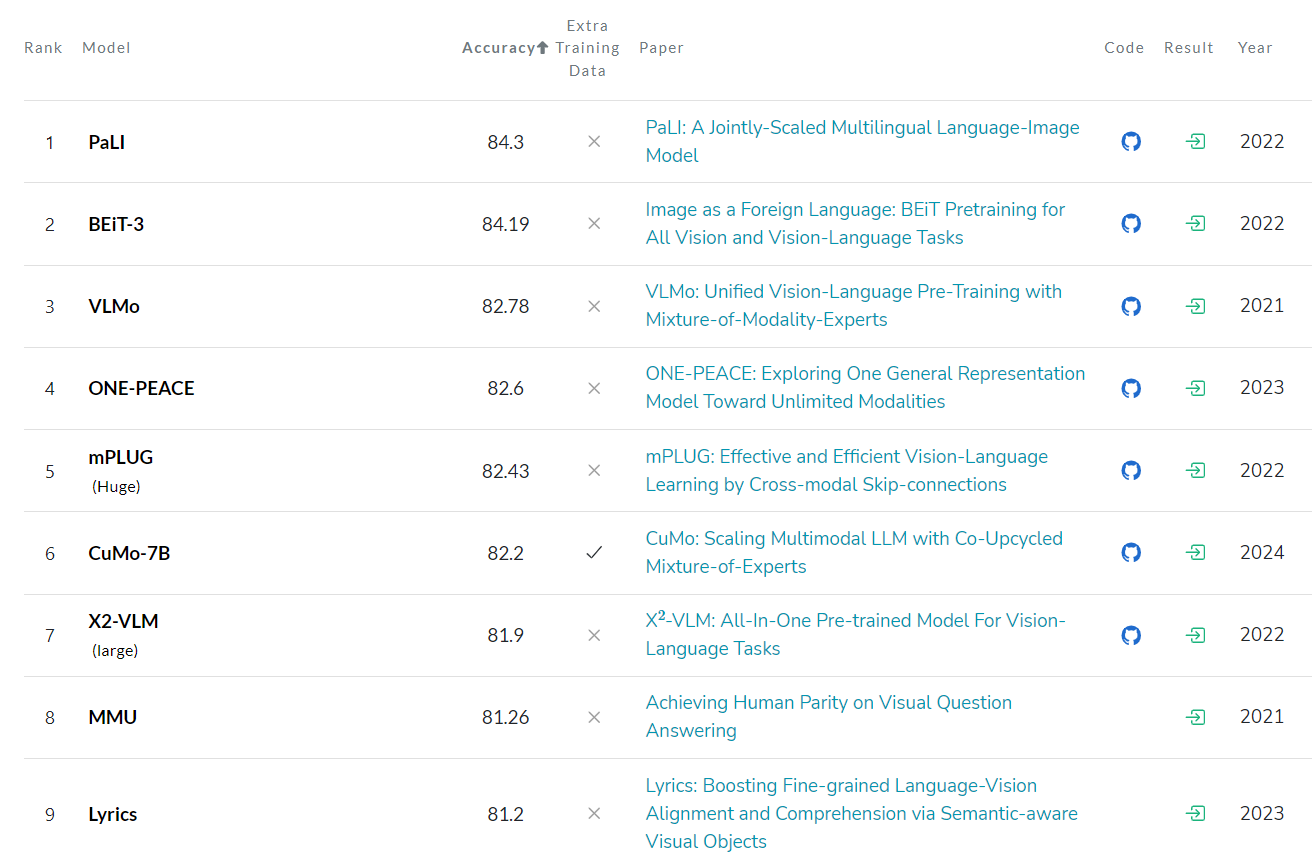

Load huggingface dataset into a PyTorch dataset object for better downstream processing

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from datasets import load_dataset

class CustomDataset(Dataset):
    def __init__(self, split='train'):
        self.data = load_dataset("Anonymous1234565/CHIRP", trust_remote_code=True, split="train")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            "image": sample["image"], # Should be a PIL image
            "question": sample["question"],
            "answer": sample["example_response"],
        }


generator1 = torch.Generator().manual_seed(42)
dataset = CustomDataset()
dataset_length = len(dataset)
train_dataset, val_dataset, rest = random_split(dataset, [0.3,0.1, 0.6], generator=generator1)
datasets = {
    "train": train_dataset,
    "val": val_dataset,
}
del rest

In [ ]:
train_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=640x640>,
 'question': 'What could the bending tree with a backwards running clock hanging from it symbolize in this image?',
 'answer': 'The backwards running clock hanging from the bent tree might symbolize a desire to turn back time or yearning for moments passed. The silhouette of the leafless tree bending towards the colorful sky could depict a longing for something unreachable or the relentlessness of nature against time.'}

Load the moondream model along with the acceptable tokenizer

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-05-20"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    # attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.29k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/48.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
moondream

Moondream(
  (vision_encoder): VisionEncoder(
    (encoder): EncoderWrapper(
      (model): ModuleDict(
        (visual): VisionTransformer(
          (patch_embed): LinearPatchEmbedding(
            (linear): Linear(in_features=588, out_features=1152, bias=True)
          )
          (blocks): Sequential(
            (0): VitBlock(
              (attn): Attention(
                (qkv): Linear(in_features=1152, out_features=3456, bias=True)
                (proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (mlp): MLP(
                (fc1): Linear(in_features=1152, out_features=4304, bias=True)
                (act): GELU(approximate='tanh')
                (fc2): Linear(in_features=4304, out_features=1152, bias=True)
              )
              (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
            )
            (1): VitBlock(
              (a

Using the pre trained model on train data

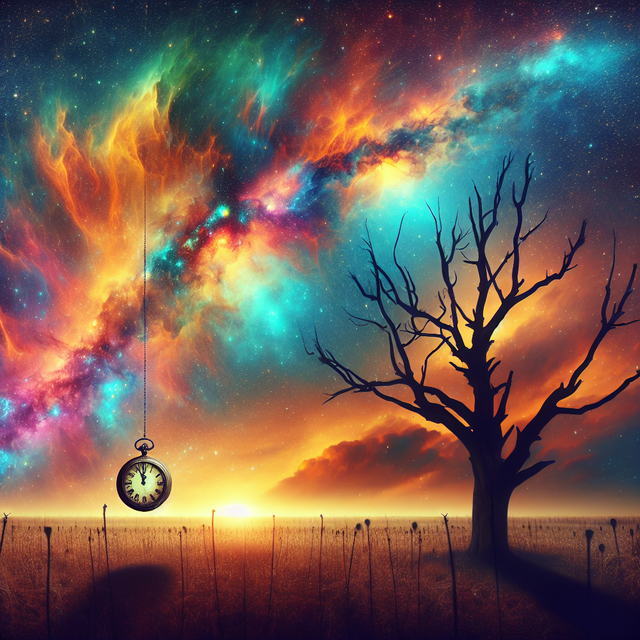

Question: What could the bending tree with a backwards running clock hanging from it symbolize in this image?
Ground Truth: The backwards running clock hanging from the bent tree might symbolize a desire to turn back time or yearning for moments passed. The silhouette of the leafless tree bending towards the colorful sky could depict a longing for something unreachable or the relentlessness of nature against time.
Moondream: The bending tree with a backwards running clock hanging from it in the image could symbolize the passage of time and the impermanence of life. The clock represents the constant flow of time, while the tree represents life and nature. The juxtaposition of the clock and the tree in a surreal and artistic setting might evoke feelings of contemplation about the fleeting nature of life and the importance of appreciating the present moment. The image can also be interpreted as a reminder to cherish the time we have and to make the most of our lives, as time is a limited 

In [ ]:
from IPython.display import display

sample = datasets['train'][0]
display(sample['image'])

print('Question:', sample['question'])
print('Ground Truth:', sample['answer'])
print('Moondream:', moondream.answer_question(
    moondream.encode_image(sample['image']),
    sample['question'],
    tokenizer=tokenizer,
))

Prep and finetune

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 1

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory.
BATCH_SIZE = 3

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 1e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(image) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        q_t = tokenizer(f"\n\nQuestion: {sample['question']}\n\nAnswer:",
            add_special_tokens=False
        ).input_ids
        toks.extend(q_t)
        labs.extend([-100] * len(q_t))
        a_t = tokenizer(
            f" {sample['answer']}{ANSWER_EOS}",
            add_special_tokens=False
        ).input_ids
        toks.extend(a_t)
        labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

if USE_WANDB:
    wandb.finish()

Epoch 1/1: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


In [ ]:
moondream.save_pretrained("checkpoints/moondream-ft", push_to_hub=True, repo_id="yeshavyas27/moondream-ft")

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

# Inference on finetuned model


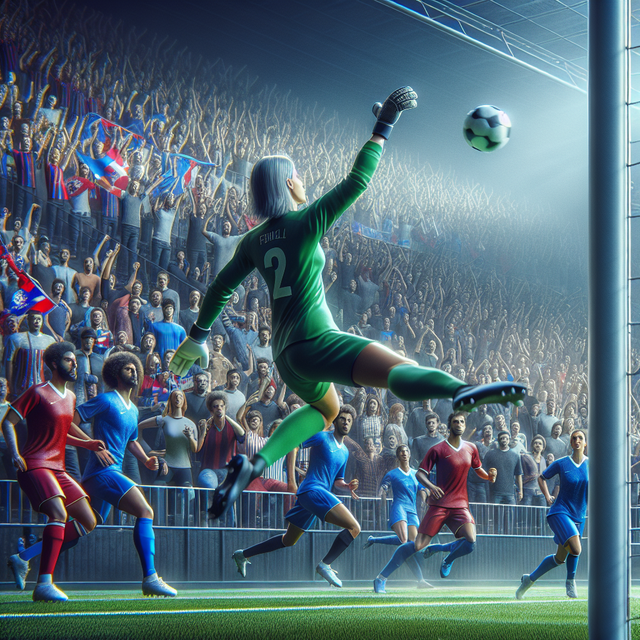

Question: Based on the depicted scene, can you infer and describe the consequences if the blue team goalie fails to stop the ball?
Ground Truth: If the blue team goalie fails to stop the ball, it would likely result in the red team scoring a goal. This could potentially lead to several changes in the dynamic of the game. The blue team might face demotivation, leading them to change their game strategy to prevent further goals. The red team, enthused by their score, might increase their offensive moves. The crowd's reaction would also significantly change. The supporters of the red team would be ecstatic, while the blue team's supporters would potentially show signs of disappointment or even agitation. Depending on when this takes place in a game (e.g., near the end or the beginning), it might majorly shift the game's momentum, possibly being the defining moment of the match.
Moondream: If the blue team goalie fails to stop the ball, it could result in a goal being scored by the opposin

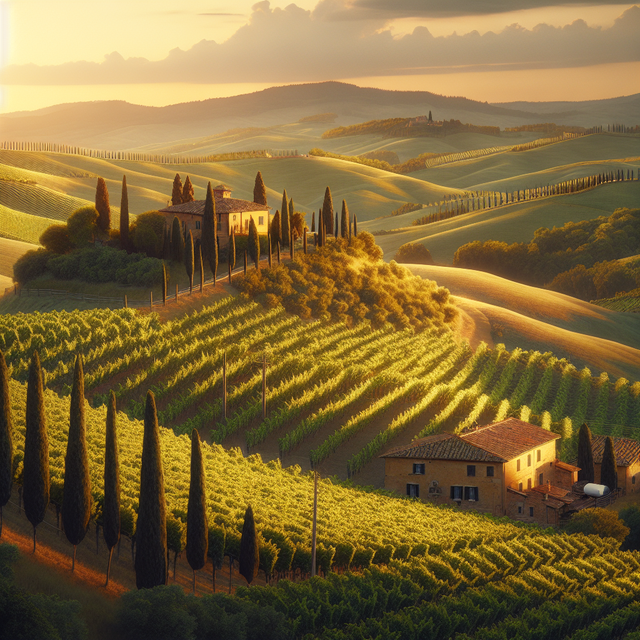

Question: Can you characterize the lifestyle, culture, and potential occupation of the people residing in this region, as hinted by the image?
Ground Truth: The image showcases the Tuscan countryside in Italy, suggesting a lifestyle deeply rooted in agriculture. The lush vineyards indicate a possible occupation in viticulture, and perhaps wine production. This, coupled with the traditional Tuscan architecture, underscores a culture that values simplicity, history, and a strong connection with the natural environment.
Moondream: Based on the image, the people residing in this region likely have a strong connection to agriculture and the countryside lifestyle. The presence of vineyards and farmlands suggests that they might be involved in farming, winemaking, or other agricultural activities. Their occupation could range from farmers, vineyard owners, winemakers, or even tour guides showcasing the beauty of the countryside. Additionally, the picturesque landscape with rolling hills, vine

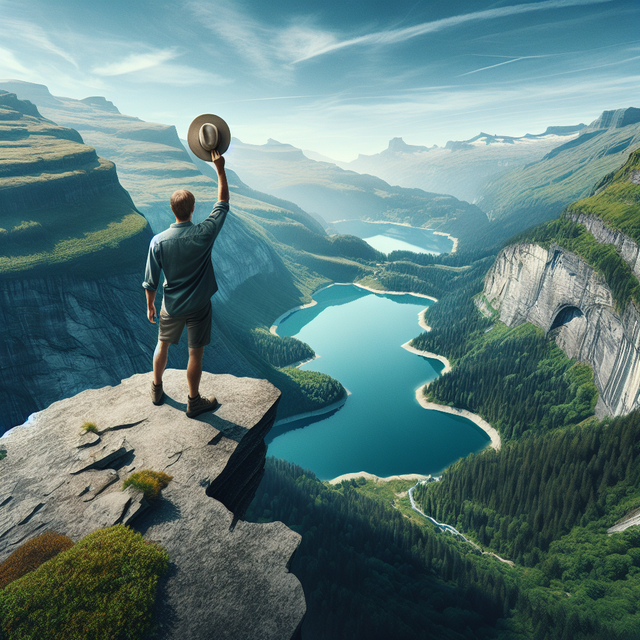

Question: What potential risks might this person be facing at this moment if the weather suddenly turned foul?
Ground Truth: Visibility would likely drop with the foul weather and the path might become slippery, increasing the risk of accidents. The person might also be exposed to the elements like rain or high winds which can be dangerous on a cliff’s edge. Travel in and out of the area might be hindered, so leaving promptly might not be possible.
Moondream: If the weather suddenly turned foul, the person standing on the edge of the cliff overlooking the lake might face several potential risks. These risks include losing their balance and falling off the cliff, which could result in severe injuries or even death. Additionally, the sudden change in weather conditions could also affect visibility, making it difficult for the person to navigate their surroundings and increasing the risk of getting lost or disoriented. It is essential for the person to be aware of their surroundings and t

In [ ]:
moondream.eval()

for i, sample in enumerate(datasets['val']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    if i < 3:
        display(sample['image'])
        print('Question:', sample['question'])
        print('Ground Truth:', sample['answer'])
        print('Moondream:', md_answer)
    else:
        break